In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
# import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import shapely.geometry as sgeom
from itertools import chain
import copy
%matplotlib inline

In [2]:
# PHASE = 'Summer'
PHASE = 'Winter'

lifetime_bounds = [2,100]
region = 'tropics'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160810_20160910'
    datetime_range = pd.to_datetime(['2016-08-10T00', '2016-09-11T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200201_20200301'
    datetime_range = pd.to_datetime(['2020-02-01T00', '2020-03-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'
dir_PyFLEXTRKR = f'{rootdir}PyFLEXTRKR/'
dir_MOAAP = f'{rootdir}MOAAP/'
dir_TOOCAN = f'{rootdir}TOOCAN/'
dir_tobac = f'{rootdir}tobac/'
dir_TAMS = f'{rootdir}TAMS/'
dir_simpleTrack = f'{rootdir}simpleTrack/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
    }

# Input filenames
filenames_PyFLEXTRKR = {key:f'{dir_PyFLEXTRKR}mcs_counts_gridmap_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_MOAAP = {key:f'{dir_MOAAP}mcs_counts_gridmap_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_TOOCAN = {key:f'{dir_TOOCAN}mcs_counts_gridmap_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_tobac = {key:f'{dir_tobac}mcs_counts_gridmap_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_TAMS = {key:f'{dir_TAMS}mcs_counts_gridmap_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_simpleTrack = {key:f'{dir_simpleTrack}mcs_counts_gridmap_{PHASE}_{value}.nc' for key,value in name_map.items()}

topfile = '/global/cfs/cdirs/m1867/zfeng/gpm/map_data/era5_orography.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/


## Check if input files exist

In [3]:
for key, value in filenames_PyFLEXTRKR.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_counts_gridmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_counts_gridmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_counts_gridmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_counts_gridmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_counts_gridmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_counts_gridmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_counts_gridmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_counts_gridmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_counts_gridmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_counts_gridmap_Winter_GEOS.nc: True
/pscrat

In [4]:
for key, value in filenames_MOAAP.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_counts_gridmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_counts_gridmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_counts_gridmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_counts_gridmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_counts_gridmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_counts_gridmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_counts_gridmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_counts_gridmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_counts_gridmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_counts_gridmap_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs

In [5]:
for key, value in filenames_TOOCAN.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_counts_gridmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_counts_gridmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_counts_gridmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_counts_gridmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_counts_gridmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_counts_gridmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_counts_gridmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_counts_gridmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_counts_gridmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_counts_gridmap_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter

In [6]:
for key, value in filenames_tobac.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_counts_gridmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_counts_gridmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_counts_gridmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_counts_gridmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_counts_gridmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_counts_gridmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_counts_gridmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_counts_gridmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_counts_gridmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_counts_gridmap_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs

In [7]:
for key, value in filenames_TAMS.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_counts_gridmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_counts_gridmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_counts_gridmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_counts_gridmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_counts_gridmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_counts_gridmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_counts_gridmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_counts_gridmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_counts_gridmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_counts_gridmap_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_counts_gri

In [8]:
for key, value in filenames_simpleTrack.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_counts_gridmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_counts_gridmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_counts_gridmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_counts_gridmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_counts_gridmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_counts_gridmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_counts_gridmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_counts_gridmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_counts_gridmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_counts_gridmap_Winter_GEOS.nc: Tr

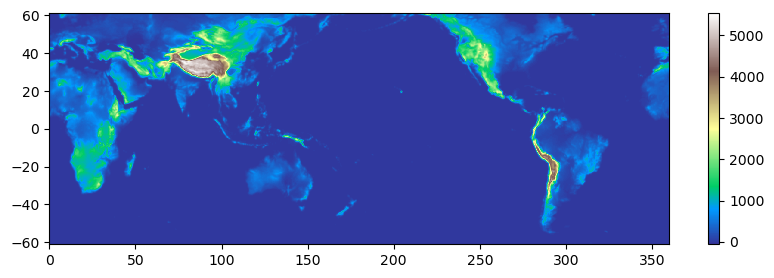

In [9]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.z.sel(latitude=slice(61,-61)).squeeze() / 9.80665
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.longitude
lat_ter = dstop.latitude.sel(latitude=slice(61,-61))

fig = plt.figure(figsize=[10,3], dpi=100)
plt.pcolormesh(lon_ter, lat_ter, ter_s, cmap='terrain')
plt.colorbar()

### Read input files

In [10]:
# Read all files and combine them with a new dimension 'source'
ds_pyflex = xr.open_mfdataset(list(filenames_PyFLEXTRKR.values()), combine='nested', concat_dim='source').squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_pyflex['source'] = list(name_map.keys())
lon = ds_pyflex['lon']
lat = ds_pyflex['lat']
lon_bnds = ds_pyflex['lon_bnds']
lat_bnds = ds_pyflex['lat_bnds']
ds_pyflex

<xarray.Dataset>
Dimensions:       (source: 11, lat: 120, lon: 360, lat_bnds: 121, lon_bnds: 361)
Coordinates:
    time          datetime64[ns] 2020-02-01
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
  * lon           (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat_bnds      (lat_bnds) float64 -60.0 -59.0 -58.0 -57.0 ... 58.0 59.0 60.0
  * lon_bnds      (lon_bnds) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
  * source        (source) <U3 'obs' 'm1' 'm2' 'm3' ... 'm8' 'm9' 'm10' 'm11'
Data variables:
    track_counts  (source, lat, lon) float32 dask.array<chunksize=(1, 120, 360), meta=np.ndarray>
Attributes:
    Title:       MCS track counts on grid
    phase:       Winter
    tracker:     PyFLEXTRKR
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Sun Nov  5 22:29:10 2023

In [11]:
# Read all files and combine them with a new dimension 'source'
ds_moaap = xr.open_mfdataset(list(filenames_MOAAP.values()), combine='nested', concat_dim='source').squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_moaap['source'] = list(name_map.keys())
ds_moaap

<xarray.Dataset>
Dimensions:       (source: 11, lat: 120, lon: 360, lat_bnds: 121, lon_bnds: 361)
Coordinates:
    time          datetime64[ns] 2020-02-01
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
  * lon           (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat_bnds      (lat_bnds) float64 -60.0 -59.0 -58.0 -57.0 ... 58.0 59.0 60.0
  * lon_bnds      (lon_bnds) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
  * source        (source) <U3 'obs' 'm1' 'm2' 'm3' ... 'm8' 'm9' 'm10' 'm11'
Data variables:
    track_counts  (source, lat, lon) float32 dask.array<chunksize=(1, 120, 360), meta=np.ndarray>
Attributes:
    Title:       MCS track counts on grid
    phase:       Winter
    tracker:     MOAAP
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Sun Nov  5 22:31:59 2023

In [12]:
# Read all files and combine them with a new dimension 'source'
ds_toocan = xr.open_mfdataset(list(filenames_TOOCAN.values()), combine='nested', concat_dim='source').squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_toocan['source'] = list(name_map.keys())
ds_toocan

<xarray.Dataset>
Dimensions:       (source: 11, lat: 120, lon: 360, lat_bnds: 121, lon_bnds: 361)
Coordinates:
    time          datetime64[ns] 2020-02-01
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
  * lon           (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat_bnds      (lat_bnds) float64 -60.0 -59.0 -58.0 -57.0 ... 58.0 59.0 60.0
  * lon_bnds      (lon_bnds) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
  * source        (source) <U3 'obs' 'm1' 'm2' 'm3' ... 'm8' 'm9' 'm10' 'm11'
Data variables:
    track_counts  (source, lat, lon) float32 dask.array<chunksize=(1, 120, 360), meta=np.ndarray>
Attributes:
    Title:       MCS track counts on grid
    phase:       Winter
    tracker:     TOOCAN
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Sun Nov  5 22:32:14 2023

In [13]:
# Read all files and combine them with a new dimension 'source'
ds_tobac = xr.open_mfdataset(list(filenames_tobac.values()), combine='nested', concat_dim='source').squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_tobac['source'] = list(name_map.keys())
lon = ds_tobac['lon']
lat = ds_tobac['lat']
lon_bnds = ds_tobac['lon_bnds']
lat_bnds = ds_tobac['lat_bnds']
ds_tobac

<xarray.Dataset>
Dimensions:       (source: 11, lat: 120, lon: 360, lat_bnds: 121, lon_bnds: 361)
Coordinates:
    time          datetime64[ns] 2020-02-01
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
  * lon           (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat_bnds      (lat_bnds) float64 -60.0 -59.0 -58.0 -57.0 ... 58.0 59.0 60.0
  * lon_bnds      (lon_bnds) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
  * source        (source) <U3 'obs' 'm1' 'm2' 'm3' ... 'm8' 'm9' 'm10' 'm11'
Data variables:
    track_counts  (source, lat, lon) float32 dask.array<chunksize=(1, 120, 360), meta=np.ndarray>
Attributes:
    Title:       MCS track counts on grid
    phase:       Winter
    tracker:     tobac
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Wed Dec 27 16:33:54 2023

In [14]:
# Read all files and combine them with a new dimension 'source'
ds_tams = xr.open_mfdataset(list(filenames_TAMS.values()), combine='nested', concat_dim='source').squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_tams['source'] = list(name_map.keys())
lon = ds_tams['lon']
lat = ds_tams['lat']
lon_bnds = ds_tams['lon_bnds']
lat_bnds = ds_tams['lat_bnds']
ds_tams

<xarray.Dataset>
Dimensions:       (source: 11, lat: 120, lon: 360, lat_bnds: 121, lon_bnds: 361)
Coordinates:
    time          datetime64[ns] 2020-02-01
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
  * lon           (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat_bnds      (lat_bnds) float64 -60.0 -59.0 -58.0 -57.0 ... 58.0 59.0 60.0
  * lon_bnds      (lon_bnds) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
  * source        (source) <U3 'obs' 'm1' 'm2' 'm3' ... 'm8' 'm9' 'm10' 'm11'
Data variables:
    track_counts  (source, lat, lon) float32 dask.array<chunksize=(1, 120, 360), meta=np.ndarray>
Attributes:
    Title:       MCS track counts on grid
    phase:       Winter
    tracker:     TAMS
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Wed Dec 27 16:42:55 2023

In [15]:
# Read all files and combine them with a new dimension 'source'
ds_simtrack = xr.open_mfdataset(list(filenames_simpleTrack.values()), combine='nested', concat_dim='source').squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_simtrack['source'] = list(name_map.keys())
lon = ds_simtrack['lon']
lat = ds_simtrack['lat']
lon_bnds = ds_simtrack['lon_bnds']
lat_bnds = ds_simtrack['lat_bnds']
ds_simtrack

<xarray.Dataset>
Dimensions:       (source: 11, lat: 120, lon: 360, lat_bnds: 121, lon_bnds: 361)
Coordinates:
    time          datetime64[ns] 2020-02-01
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
  * lon           (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat_bnds      (lat_bnds) float64 -60.0 -59.0 -58.0 -57.0 ... 58.0 59.0 60.0
  * lon_bnds      (lon_bnds) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
  * source        (source) <U3 'obs' 'm1' 'm2' 'm3' ... 'm8' 'm9' 'm10' 'm11'
Data variables:
    track_counts  (source, lat, lon) float32 dask.array<chunksize=(1, 120, 360), meta=np.ndarray>
Attributes:
    Title:       MCS track counts on grid
    phase:       Winter
    tracker:     simpleTrack
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Tue Jan  9 13:37:25 2024

In [16]:
def get_obs_model_diff(da):
    """
    Get obs, models & calculate their differences
    
    Args:
        da: DataArray
            DataArray containing multiple sources (including 'obs' & models)
            
    Returns:
        da_obs: DataArray
            DataArray containing observation
        da_mod: DataArray
            DataArray containing models
        da_diff: DataArray
            DataArray containing differences    
    """
    # Select non-obs sources (models) & obs
    da_mod = da.isel(source=da['source'] != 'obs').squeeze()
    da_obs = da.sel(source='obs').squeeze()
    # Compute the difference (model - obs)
    da_diff = da_mod - da_obs
    return (da_obs, da_mod, da_diff)

In [17]:
# Get obs, models, & differences
counts_obs_pyflex, counts_mod_pyflex, counts_diff_pyflex = get_obs_model_diff(ds_pyflex['track_counts'])

counts_obs_moaap, counts_mod_moaap, counts_diff_moaap = get_obs_model_diff(ds_moaap['track_counts'])

counts_obs_toocan, counts_mod_toocan, counts_diff_toocan = get_obs_model_diff(ds_toocan['track_counts'])

counts_obs_tobac, counts_mod_tobac, counts_diff_tobac = get_obs_model_diff(ds_tobac['track_counts'])

counts_obs_tams, counts_mod_tams, counts_diff_tams = get_obs_model_diff(ds_tams['track_counts'])

counts_obs_simtrack, counts_mod_simtrack, counts_diff_simtrack = get_obs_model_diff(ds_simtrack['track_counts'])

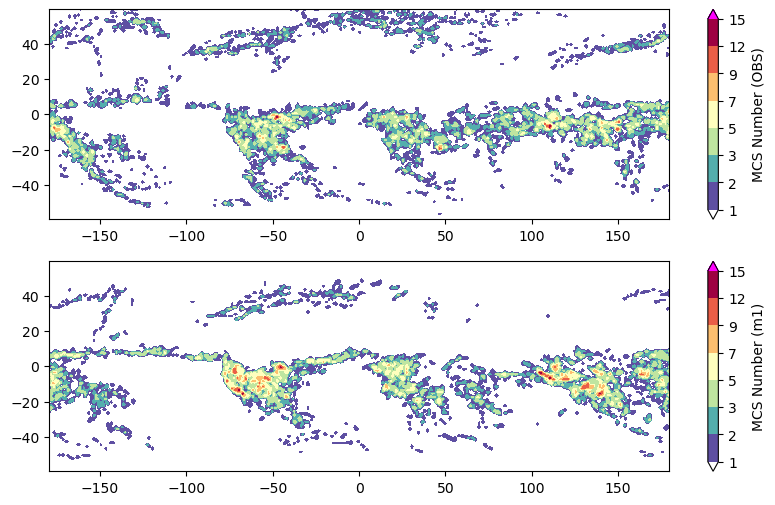

In [18]:
fig, axes = plt.subplots(2, 1, figsize=[10,6], dpi=100)
# levels = [1,2,4,7,10,13,16,20]
levels = [1,2,3,5,7,9,12,15]
cmap = copy.copy(mpl.colormaps.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
cmap.set_over('magenta')
cmap.set_under('white')
ax1 = axes[0]
pcm1 = ax1.contourf(lon, lat, counts_obs_pyflex, levels=levels, norm=norm, cmap=cmap, extend='both')
plt.colorbar(pcm1, label='MCS Number (OBS)')

ax2 = axes[1]
pcm2 = ax2.contourf(lon, lat, counts_mod_pyflex.sel(source='m1'), levels=levels, norm=norm, cmap=cmap, extend='both')
plt.colorbar(pcm2, label='MCS Number (m1)')

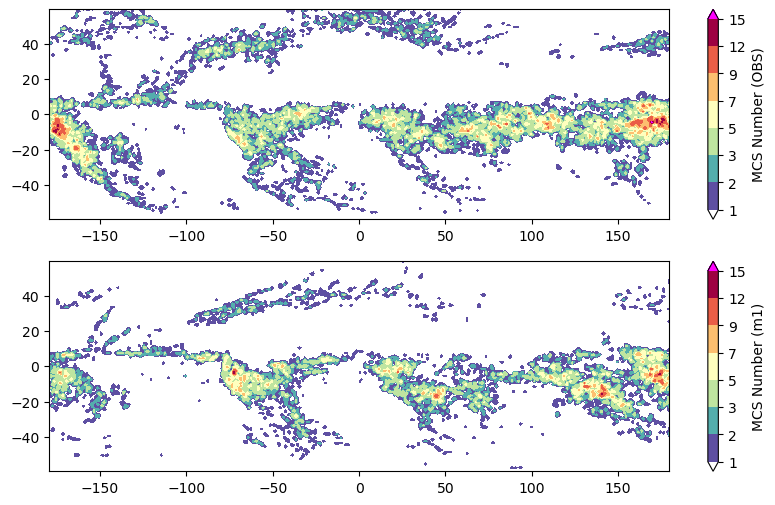

In [19]:
fig, axes = plt.subplots(2, 1, figsize=[10,6], dpi=100)
# levels = [1,2,4,7,10,13,16,20]
levels = [1,2,3,5,7,9,12,15]
cmap = copy.copy(mpl.colormaps.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
cmap.set_over('magenta')
cmap.set_under('white')
ax1 = axes[0]
pcm1 = ax1.contourf(lon, lat, counts_obs_moaap, levels=levels, norm=norm, cmap=cmap, extend='both')
plt.colorbar(pcm1, label='MCS Number (OBS)')

ax2 = axes[1]
pcm2 = ax2.contourf(lon, lat, counts_mod_moaap.sel(source='m1'), levels=levels, norm=norm, cmap=cmap, extend='both')
plt.colorbar(pcm2, label='MCS Number (m1)')

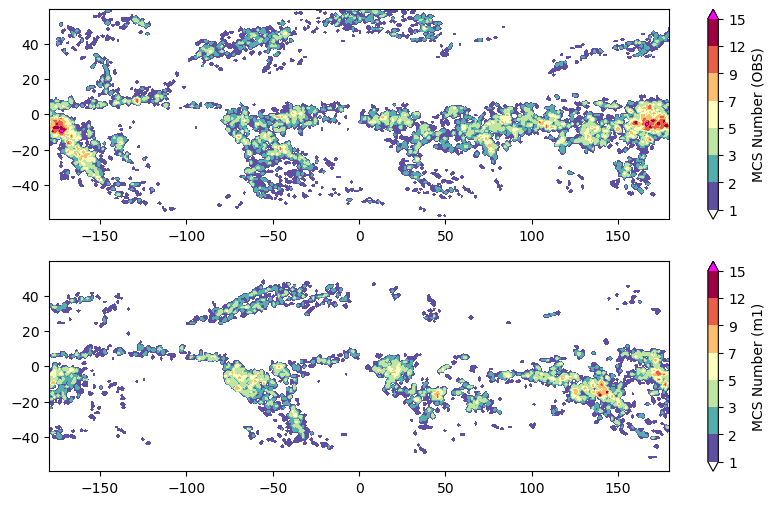

In [20]:
fig, axes = plt.subplots(2, 1, figsize=[10,6], dpi=100)
# levels = [1,2,4,7,10,13,16,20]
levels = [1,2,3,5,7,9,12,15]
cmap = copy.copy(mpl.colormaps.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
cmap.set_over('magenta')
cmap.set_under('white')
ax1 = axes[0]
pcm1 = ax1.contourf(lon, lat, counts_obs_toocan, levels=levels, norm=norm, cmap=cmap, extend='both')
plt.colorbar(pcm1, label='MCS Number (OBS)')

ax2 = axes[1]
pcm2 = ax2.contourf(lon, lat, counts_mod_toocan.sel(source='m1'), levels=levels, norm=norm, cmap=cmap, extend='both')
plt.colorbar(pcm2, label='MCS Number (m1)')

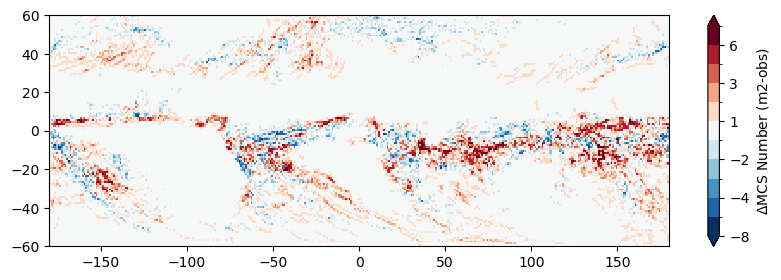

In [21]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = [-8,-6,-4,-3,-2,-1,1,2,3,4,6,8]
cbticks = levels
# cmap = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmap = mpl.colormaps.get_cmap('RdBu_r')
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
plt.pcolormesh(lon, lat, counts_diff_pyflex.sel(source='m2'), norm=norm, cmap=cmap)
plt.colorbar(label='$\Delta$MCS Number (m2-obs)', extend='both')

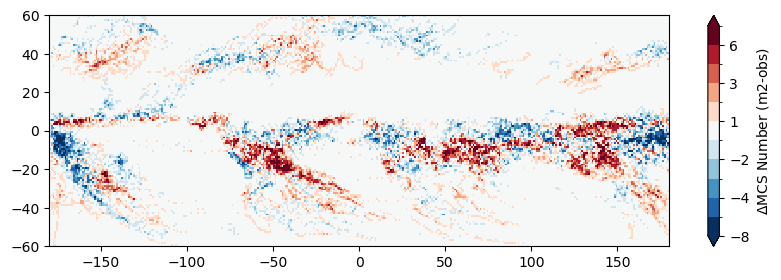

In [22]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = [-8,-6,-4,-3,-2,-1,1,2,3,4,6,8]
cbticks = levels
# cmap = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmap = mpl.colormaps.get_cmap('RdBu_r')
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
plt.pcolormesh(lon, lat, counts_diff_moaap.sel(source='m2'), norm=norm, cmap=cmap)
plt.colorbar(label='$\Delta$MCS Number (m2-obs)', extend='both')

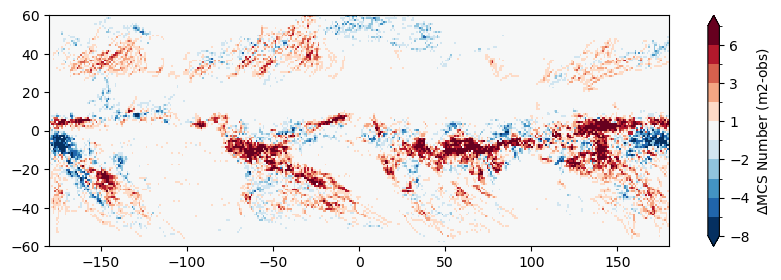

In [23]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = [-8,-6,-4,-3,-2,-1,1,2,3,4,6,8]
cbticks = levels
# cmap = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmap = mpl.colormaps.get_cmap('RdBu_r')
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
plt.pcolormesh(lon, lat, counts_diff_toocan.sel(source='m2'), norm=norm, cmap=cmap)
plt.colorbar(label='$\Delta$MCS Number (m2-obs)', extend='both')

## Specify regional boundaries for calculating mean values

In [24]:
if PHASE == 'Winter':
    box_tropics = [-180, 180, -30, 12]
    boxes = {
        'Tropics':box_tropics,
        # 'Ocean':box_tropics,
    }
    region_names = dict(zip(boxes.keys(), boxes.keys()))
    
    # Text location
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    text_loc_y = [
        boxes['Tropics'][3]+3,
        # boxes['Ocean'][3]+3,
    ]
    text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

In [25]:
if PHASE == 'Summer':
    box_tropics = [-180, 180, -12, 30]
    boxes = {
        'Tropics':box_tropics,
        # 'Ocean':box_tropics,
    }
    region_names = dict(zip(boxes.keys(), boxes.keys()))
    
    # Text location
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    text_loc_y = [
        boxes['Tropics'][3]+3,
        # boxes['Ocean'][3]+3,
    ]
    text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

In [26]:
# if PHASE == 'Winter':
#     box_mc = [95%360,150%360,-20,5]
#     box_itcz = [151%360,-110%360,0,12]
#     box_spcz = [151%360,-150%360,-30,-1]
#     box_io = [50%360,94%360,-15,5]
#     box_afc = [10%360,40%360,-20,5]
#     box_amz = [-75%360,-40%360,-20,0]
#     box_ao = [-40%360,-10%360,-8,8]
#     boxes = {'MC':box_mc, 
#              'ITCZ':box_itcz, 
#              'SPCZ':box_spcz, 
#              'IO':box_io, 
#              'AO':box_ao,
#              'AFC':box_afc, 
#              'AMZ':box_amz, 
#              }
#     region_names = dict(zip(boxes.keys(), boxes.keys()))
    
#     # Calculate regional mean difference
#     diff_reg = np.zeros(len(boxes), dtype=float)
#     text_loc_x = np.zeros(len(boxes), dtype=float)
#     for ii, name in enumerate(boxes):
#         text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
#     text_loc_y = [
#         boxes['MC'][3]+3,
#         boxes['ITCZ'][3]+3,
#         boxes['SPCZ'][2]-8, 
#         boxes['IO'][2]-8, 
#         boxes['AO'][3]+3,
#         boxes['AFC'][2]-8, 
#         boxes['AMZ'][2]-8, 
#     ]
#     text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
#     text_loc['SPCZ'] = text_loc['SPCZ'][0] + 20, text_loc['SPCZ'][1]

In [27]:
# if PHASE == 'Summer':
#     box_mc = [95,150,-20,5]
#     box_itcz = [-179,-70,5,18]
#     box_io = [50,94,-15,5]
#     box_wpac = [125,178,0,30]
#     box_sam = [70,125,5,40]
#     box_afc = [-15,40,-5,18]
#     box_amz = [-75,-40,-20,0]
#     box_ao = [-60,-15,5,18]
#     box_cus = [-105, -80, 30, 50]
#     box_ao180 = [-60,-15,5,18]
#     box_cus180 = [-105, -80, 30, 50]
#     boxes = {
#         'WP':box_wpac,
#         'ITCZ':box_itcz, 
#         'IO':box_io, 
#         'AO':box_ao,
#         'AFC':box_afc, 
#         'SAM':box_sam,
#         'CUS':box_cus,
#     }
#     region_names = dict(zip(boxes.keys(), boxes.keys()))
    
#     # Calculate regional mean difference
#     diff_reg = np.zeros(len(boxes), dtype=float)
#     text_loc_x = np.zeros(len(boxes), dtype=float)
#     for ii, name in enumerate(boxes):
#         text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
#     text_loc_y = [
#         boxes['WP'][3]+3,
#         boxes['ITCZ'][3]+3, 
#         boxes['IO'][2]-8, 
#         boxes['AO'][3]+3,
#         boxes['AFC'][2]-8, 
#         boxes['SAM'][3]+3,
#         boxes['CUS'][3]+3,
#     ]
#     text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

## Function to calculate regional mean percentage differernce

In [28]:
def calc_regional_diff_percent(da, boxes):
    """
    Calculate regional mean percentage difference
    Args:
        da: DataArray
            Data Array containing dimensions (source, lat, lon)
        boxes: dictionary
            Dictionary containing region names and lat/lon bounds
        
    Returns:
        dict_out: dictionary
            Dictionary containing mean difference for each box.
    """
    # Get number of sources (-1)
    nsource = da.sizes['source']-1
    # Get number of boxes
    nbox = len(boxes)
    # Get source names (exclude first one 'obs')
    source_names = list(da.source.data[1:])
    
    # Make arrays to store the differences
    diff_reg = np.zeros((nsource,nbox), dtype=float)
    text_loc_x = np.zeros((nsource,nbox), dtype=float)
    
    # Loop over each region
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
        
        # Select (subset) the region
        ida = da.sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)        
        # Select non-obs sources, sum over the region
        ida_mod = ida.isel(source=ida['source'] != 'obs').sum(dim=('lat','lon'))
        # Select obs, sum over the region
        ida_obs = ida.sel(source='obs').sum(dim=('lat','lon'))

        # Calculate fractional difference
        diff_reg[:,ii] = 100 * (ida_mod - ida_obs) / ida_obs
        
    # Put values in dictionary
    dict_out = dict(zip(source_names, diff_reg))
    # print(dict_out)
    
    return dict_out

In [29]:
dict_counts_pyflex = calc_regional_diff_percent(ds_pyflex.track_counts, boxes)
print(dict_counts_pyflex)

{'m1': array([13.28628635]), 'm2': array([6.54135847]), 'm3': array([-21.30012894]), 'm5': array([12.2616539]), 'm6': array([-16.01411438]), 'm7': array([-50.81766891]), 'm8': array([-15.668046]), 'm9': array([34.97319794]), 'm10': array([-0.27142566]), 'm11': array([48.42912292])}


In [30]:
dict_counts_moaap = calc_regional_diff_percent(ds_moaap.track_counts, boxes)
print(dict_counts_moaap)

{'m1': array([-18.64710426]), 'm2': array([-11.96366119]), 'm3': array([-32.47888947]), 'm5': array([-41.98583984]), 'm6': array([-24.4775219]), 'm7': array([-87.7591095]), 'm8': array([-71.2530899]), 'm9': array([13.43512726]), 'm10': array([-33.8693161]), 'm11': array([-7.69001102])}


In [31]:
dict_counts_toocan = calc_regional_diff_percent(ds_toocan.track_counts, boxes)
print(dict_counts_toocan)

{'m1': array([-29.07214165]), 'm2': array([28.22763062]), 'm3': array([2.37346148]), 'm5': array([-41.11607742]), 'm6': array([-34.05089188]), 'm7': array([-85.40597534]), 'm8': array([-51.06805801]), 'm9': array([3.20693278]), 'm10': array([-19.31335258]), 'm11': array([-77.1098938])}


In [32]:
dict_counts_tobac = calc_regional_diff_percent(ds_tobac.track_counts, boxes)
print(dict_counts_tobac)

{'m1': array([19.25962448]), 'm2': array([50.47964478]), 'm3': array([-18.27573395]), 'm5': array([10.36157894]), 'm6': array([1.9923749]), 'm7': array([-73.82241058]), 'm8': array([-20.88918877]), 'm9': array([36.05337524]), 'm10': array([4.20612478]), 'm11': array([-2.90862131])}


In [33]:
dict_counts_tams = calc_regional_diff_percent(ds_tams.track_counts, boxes)
print(dict_counts_tams)

{'m1': array([33.22764206]), 'm2': array([27.91384125]), 'm3': array([-38.31182861]), 'm5': array([40.56418228]), 'm6': array([-9.81849957]), 'm7': array([-27.31248665]), 'm8': array([25.47561836]), 'm9': array([37.07631683]), 'm10': array([12.94554996]), 'm11': array([38.92411804])}


In [34]:
dict_counts_simtrack = calc_regional_diff_percent(ds_simtrack.track_counts, boxes)
print(dict_counts_simtrack)

{'m1': array([16.24845123]), 'm2': array([12.55947304]), 'm3': array([-52.16059494]), 'm5': array([15.65534782]), 'm6': array([-22.38154221]), 'm7': array([-30.13100433]), 'm8': array([9.41797543]), 'm9': array([16.99146271]), 'm10': array([2.71785188]), 'm11': array([24.51932526])}


In [35]:
region_names_all = ['PyFLEXTRKR', 'MOAAP', 'TOOCAN', 'tobac', 'TAMS', 'simpleTrack']

dict_counts_all = {}

for key in dict_counts_pyflex.keys():
    # The order must be consistent with the region_names_all
    dict_counts_all[key] = [dict_counts_pyflex[key][0], dict_counts_moaap[key][0], dict_counts_toocan[key][0], dict_counts_tobac[key][0], dict_counts_tams[key][0], dict_counts_simtrack[key][0],]

In [36]:
dict_counts_all

{'m1': [13.286286354064941,
  -18.647104263305664,
  -29.072141647338867,
  19.259624481201172,
  33.22764205932617,
  16.248451232910156],
 'm2': [6.541358470916748,
  -11.963661193847656,
  28.227630615234375,
  50.479644775390625,
  27.913841247558594,
  12.559473037719727],
 'm3': [-21.300128936767578,
  -32.47888946533203,
  2.3734614849090576,
  -18.275733947753906,
  -38.31182861328125,
  -52.16059494018555],
 'm5': [12.261653900146484,
  -41.98583984375,
  -41.1160774230957,
  10.361578941345215,
  40.56418228149414,
  15.65534782409668],
 'm6': [-16.014114379882812,
  -24.477521896362305,
  -34.0508918762207,
  1.9923748970031738,
  -9.818499565124512,
  -22.381542205810547],
 'm7': [-50.81766891479492,
  -87.75910949707031,
  -85.40597534179688,
  -73.8224105834961,
  -27.31248664855957,
  -30.131004333496094],
 'm8': [-15.668045997619629,
  -71.25308990478516,
  -51.068058013916016,
  -20.889188766479492,
  25.475618362426758,
  9.417975425720215],
 'm9': [34.97319793701172,

In [37]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Plot regional mean difference as bar chart

In [38]:
def bar_chart(dict_data, xlabels, name_map, width=None, ylabel=None, ylim=None, legend_prop=None, figsize=None, figname=None, xlabel_rotation=0):

    mpl.rcParams['font.size'] = 16
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    # labels = list(region_names.keys())
    x = np.arange(len(xlabels))
    multiplier = -((len(name_map)-1)/2)
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
    }

    # Loop over each source    
    for key, val in dict_data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, val, width, color=lcolors[key], label=name_map[key], zorder=5)
        multiplier += 1    

    # Add some text for xlabels, title and custom x-axis tick xlabels, etc.
    ax.set_ylabel(ylabel)
    # ax.set_title('', loc='left')
    # ax.set_xticks(x, xlabels)
    # Set xlabel text alignment
    xlabel_ha = 'right' if xlabel_rotation > 0 else 'center'
    ax.set_xticks(x, xlabels, rotation=xlabel_rotation, ha=xlabel_ha)
    ax.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'])
    ax.axhline(y=0, lw=1, ls='--', color='k')
    ax.grid(which='major', ls='--', axis='y')
    ax.set_ylim(ylim[0], ylim[1])
    
    # fig.tight_layout()
    
    # # Shade the background with colors
    # # Get x-axis limits
    # xmin, xmax = ax.get_xlim()
    # midpoint = (xmin + xmax) / 2
    # ax.axvspan(xmin, midpoint, facecolor='antiquewhite', alpha=0.5)
    # ax.axvspan(midpoint, xmax, facecolor='lightcyan', alpha=0.5)
    
    # fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [39]:
region_names_all

['PyFLEXTRKR', 'MOAAP', 'TOOCAN', 'tobac', 'TAMS', 'simpleTrack']

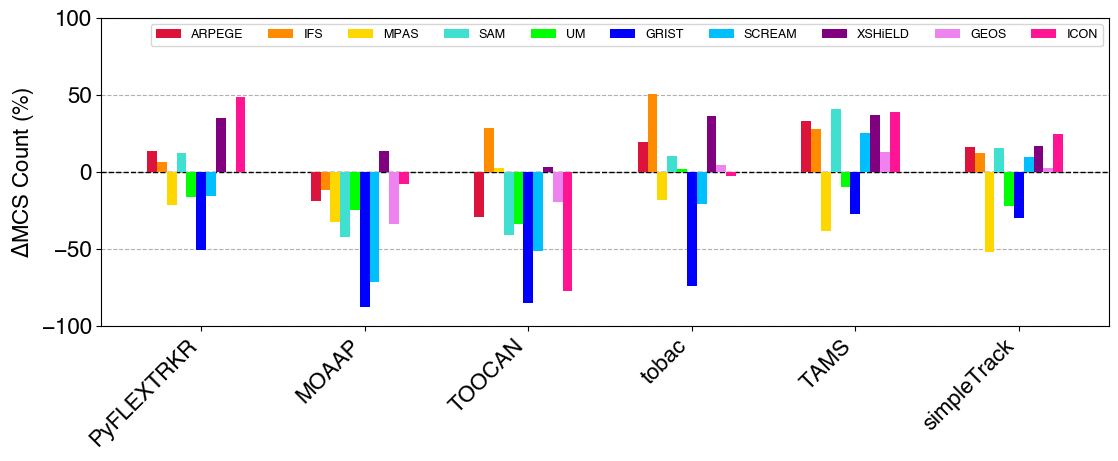

In [40]:
ylabel = f'$\Delta$MCS Count (%)'
if PHASE == 'Winter':
    ylim = (-100,100)
if PHASE == 'Summer':
    ylim = (-100,100)
width = 0.06
figsize = [13,4]
figname = f'{figdir}globalmap_mcs_counts_tropics_meandiff_barchart.png'
legend_prop = {'ncol':len(name_map)-1, 'fontsize':9}
fig = bar_chart(dict_counts_all, region_names_all, name_map, width=width, ylabel=ylabel, ylim=ylim, legend_prop=legend_prop, figsize=figsize, figname=figname, xlabel_rotation=45)

## Function to plot 1 map and bar chart

In [41]:
def plot_map_bars(data_map, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                  oob_colors=None, contourf=False, smooth_window=None, figsize=None, fontsize=None, cb_fontsize=None,
                  boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None,
                  bar_data=None, bar_width=None, bar_xlabels=None, bar_ylabel=None, legend_prop=None, bar_ylim=None, bar_xlabel_rotation=0):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    ###################################################
    # Map plot
    ###################################################
    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=figsize, dpi=100)
    h_ratios = [0.05, 1, 1]
    gs = gridspec.GridSpec(3, 1, height_ratios=h_ratios, width_ratios=[1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.25)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    ax = plt.subplot(gs[1,0], projection=proj)
    ax.set_extent(map_extent, crs=proj)
    ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(titles[0], loc='left')
    
    # Grid lines & labels
    gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)         
    # if (row == nrow-1):
    ax.set_xticks(lonv, crs=data_proj)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_yticks(latv, crs=data_proj)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    # Terrain height
    ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                    colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
    
    # Select and mask data source
    Zm = np.ma.masked_where(np.isnan(data_map), data_map)
    cmap = copy.copy(mpl.colormaps.get_cmap(cmaps))
    # Set out of bound colors
    if oob_colors is not None:
        cmap.set_over(oob_colors['over'])
        cmap.set_under(oob_colors['under'])
    norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    # Plot data
    if (contourf == False):
        cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
    else:
        Zms = gaussian_filter(Zm, smooth_window)
        cf1 = ax.contourf(lon, lat, Zms, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)

    # Colorbars
    cax1 = plt.subplot(gs[0,0])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels, ticks=cbticks, orientation='horizontal', extend='both')
    cb1.ax.xaxis.set_label_position('top')
    cb1.ax.tick_params(labelsize=cb_fontsize)
        
    # Plot boxes
    if boxes is not None:
        for ii in boxes:
            # Plot region boxes
            corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
            box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
            ax.add_patch(box)

            if boxtexttype is None:
                text_color = text_colors['pos'] if (boxtext[ii] >=0) else text_colors['neg']
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
            else:
                text_color = 'k'
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]}", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)

    
    ###################################################
    # Bar chart
    ###################################################
    width = 0.06
    ax2 = plt.subplot(gs[2,0])
    # labels = list(boxes.keys())
    x = np.arange(len(bar_xlabels))
    multiplier = -((len(name_map)-1)/2)
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
    }

    # Loop over each source    
    for key, val in bar_data.items():
        offset = bar_width * multiplier
        rects = ax2.bar(x + offset, val, bar_width, color=lcolors[key], label=name_map[key])
        multiplier += 1    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel(bar_ylabel)
    ax2.set_title(titles[1], loc='left')
    # ax2.set_xticks(x, bar_xlabels)
    # Set xlabel text alignment
    xlabel_ha = 'right' if bar_xlabel_rotation > 0 else 'center'
    ax2.set_xticks(x, bar_xlabels, rotation=bar_xlabel_rotation, ha=xlabel_ha)
    ax2.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'])
    ax2.axhline(y=0, lw=1, ls='--', color='k')
    ax2.grid(which='major', ls='--', axis='y')
    ax2.set_ylim(bar_ylim[0], bar_ylim[1])
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

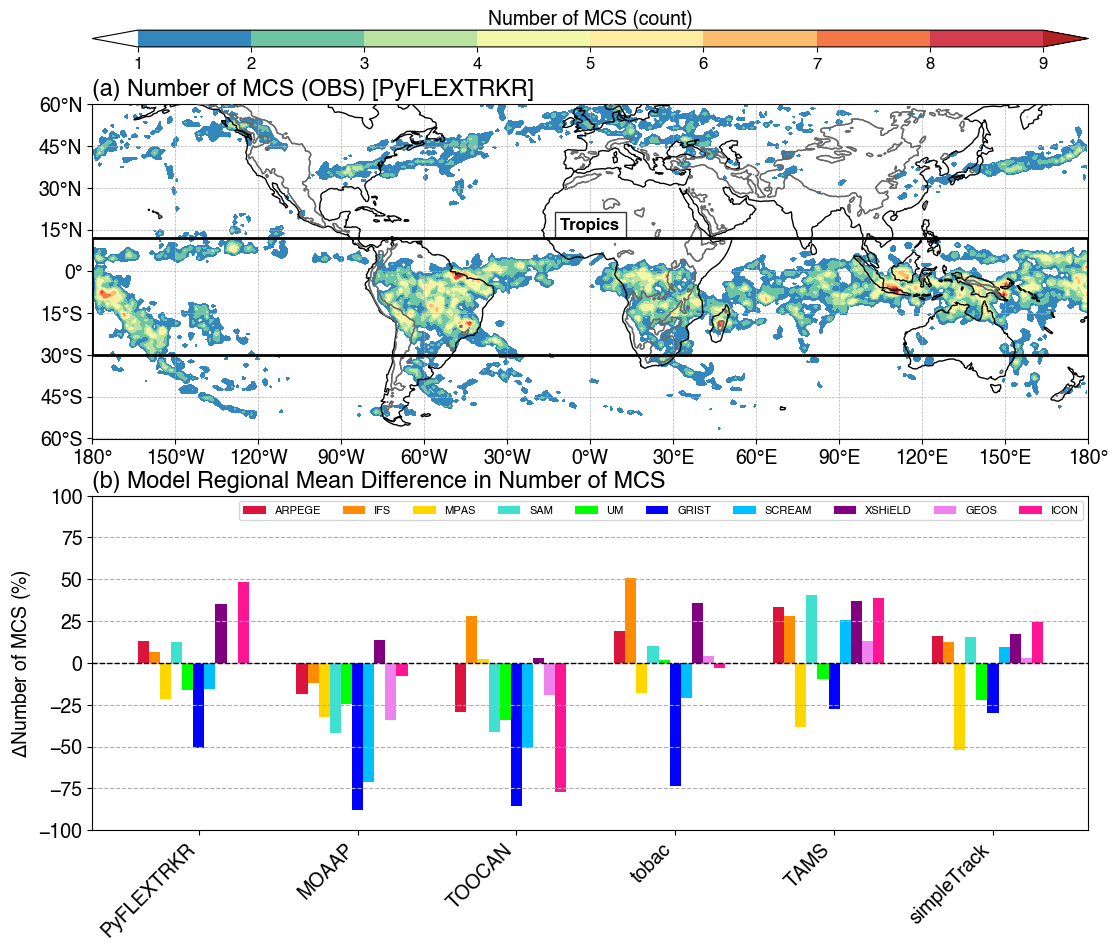

In [42]:
figsize = [12,10]
fontsize = 14
cb_fontsize = 12
varname1 = 'Number of MCS'
varname2 = '$\Delta$Number of MCS'
units = 'count'

# Map data
data_dict = counts_obs_pyflex
levels = np.arange(1,9.1,1)
cmaps = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmaps = truncate_colormap(cmaps, 0.1, 0.9)
smooth_window = 0.5
titles = [f'(a) {varname1} (OBS) [PyFLEXTRKR]', f'(b) Model Regional Mean Difference in {varname1}']
cbticks = levels
oob_colors = {'under':'white', 'over':'firebrick'}
cblabels = f'{varname1} ({units})'
text_colors = None
text_val = dict(zip(boxes.keys(),boxes.keys()))

# Bar chart data
bar_data = dict_counts_all
bar_xlabels = region_names_all
bar_ylabel = f'{varname2} (%)'
bar_ylim = (-100,100)
bar_width = 0.07
legend_prop = {'ncol':len(name_map)-1, 'fontsize':8}

figname = f'{figdir}globalmap_mcs_counts_obs_barchart_diff_all.png'

fig = plot_map_bars(data_dict, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=True, smooth_window=smooth_window, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
                    bar_data=bar_data, bar_width=bar_width, bar_xlabels=bar_xlabels, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabel_rotation=45)

In [43]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_counts_obs_barchart_diff_all.png'